# Differential Evolution For Digital Watermarking

In [1]:
import random
import cv2
import numpy as np
from DEwatermarking import watermarking
import test
from matplotlib import pyplot as plt
import encrypt
import decrypt 

### Cost Function

In [2]:
Watermarking = watermarking(level=3, cover_image = "lena.jpg")
def cost(x):
    Watermarking = watermarking(level=3, x = x, cover_image = "lena.jpg", watermark_path = "watermark1.jpg")
    Watermarking.watermark()
    Watermarking.extracted()
    test.add_gaussian_noise("watermarked_lena.jpg", output_image = "watermarked_lena.jpg")
    return Watermarking.psnr_cal(img1 = "lena.jpg", img2 = "watermarked_lena.jpg")

#with rubicks Excryption

# Watermarking = watermarking(level=3, cover_image = "lena.jpg")
# def cost(x):
#     encrypt.encrypt(input_image = "watermark1.jpg",output_image = "watermark-encrypted.jpg")
#     Watermarking = watermarking(level=3, x = x, cover_image = "lena.jpg", watermark_path = "watermark-encrypted.jpg")
#     Watermarking.watermark()
#     Watermarking.extracted()
#     decrypt.decrypt(input_image = "watermark_extracted.jpg", output_image = "watermark-decrypted.jpg")
#     return Watermarking.psnr_cal(img1 = "lena.jpg", img2 = "watermarked_lena.jpg")


In [3]:
def ensure_bounds(vec, bounds):

    vec_new = []
    # cycle through each variable in vector
    for i in range(len(vec)):

        # variable exceedes the minimum boundary
        if vec[i] < bounds[i][0]:
            vec_new.append(bounds[i][0])

        # variable exceedes the maximum boundary
        if vec[i] > bounds[i][1]:
            vec_new.append(bounds[i][1])

        # the variable is fine
        if bounds[i][0] <= vec[i] <= bounds[i][1]:
            vec_new.append(vec[i])
       
    return vec_new


#--- MAIN ---------------------------------------------------------------------+

def differential_evolution(cost_func, bounds, popsize, mutate, recombination, maxiter):

    #--- INITIALIZE A POPULATION (step #1) ----------------+
   
     #population = []
#     for i in range(0,popsize):
#         indv = []
#         for j in range(len(bounds)):
#             indv.append(random.uniform(bounds[j][0],bounds[j][1]))
#         population.append(indv)
    population = [ [0.025],
                  [0.045],
                  [0.0675],
                  [0.0666]
            ]       
    print("\nPOPULATION: ", population)
    #--- SOLVE --------------------------------------------+

    # cycle through each generation (step #2)
    for i in range(1,maxiter+1):
        print ('GENERATION:',i)

        gen_scores_psnr = [] # score keeping psnr
        gen_scores_nc = [] #score keeping nc
        # cycle through each individual in the population
        for j in range(0, popsize):

            #--- MUTATION (step #3.A) ---------------------+
           
            # select three random vector index positions [0, popsize), not including current vector (j)
            canidates = range(0,popsize)
            #canidates.remove(j)
            random_index = random.sample(canidates, 3)

            x_1 = population[random_index[0]]
            x_2 = population[random_index[1]]
            x_3 = population[random_index[2]]
            x_t = population[j]     # target individual

            # subtract x3 from x2, and create a new vector (x_diff)
            x_diff = [x_2_i - x_3_i for x_2_i, x_3_i in zip(x_2, x_3)]

            # multiply x_diff by the mutation factor (F) and add to x_1
            v_donor = [x_1_i + mutate * x_diff_i for x_1_i, x_diff_i in zip(x_1, x_diff)]
            v_donor = ensure_bounds(v_donor, bounds)

            #--- RECOMBINATION (step #3.B) ----------------+

            v_trial = []
            for k in range(len(x_t)):
                crossover = random.random()
                if crossover <= recombination:
                    v_trial.append(v_donor[k])

                else:
                    v_trial.append(x_t[k])
                   
            #--- GREEDY SELECTION (step #3.C) -------------+

            score_trial  = cost_func(v_trial)
            score_target = cost_func(x_t)
            print("\nscore_trial: ", score_trial)
            print("score_target: ", score_target)

            if score_trial > score_target:
                population[j] = v_trial
                gen_scores_psnr.append(score_trial[0])
                gen_scores_nc.append(score_trial[1])
                print ('   >',score_trial, v_trial)
                gen_sol = score_trial

            else:
                print ('   >',score_target, x_t)
                gen_scores_psnr.append(score_target[0])
                gen_scores_nc.append(score_target[1])
                gen_sol = score_target

        #--- SCORE KEEPING --------------------------------+

        gen_avg_psnr = sum(gen_scores_psnr) / popsize                         # current generation avg. fitness
        gen_best_psnr = max(gen_scores_psnr)                                  # fitness of best individual
        gen_sol_psnr = population[gen_scores_psnr.index(max(gen_scores_psnr))]     # solution of best individual

        gen_avg_nc = sum(gen_scores_nc) / popsize
        gen_best_nc = max(gen_scores_nc)
        gen_sol_nc = population[gen_scores_nc.index(max(gen_scores_nc))]
        print ('      > GENERATION AVERAGE PSNR: ',gen_avg_psnr)
        print ('      > GENERATION BEST PSNR:',gen_best_psnr)
        print ('         > BEST SOLUTION PSNR:',gen_sol_psnr,'\n')
        
        print ('      > GENERATION AVERAGE NC: ',gen_avg_nc)
        print ('      > GENERATION BEST NC:',gen_best_nc)
        print ('         > BEST SOLUTION NC:',gen_sol_nc,'\n')
        
        if gen_best_psnr > psnr_value and gen_best_nc > nc_value: 
            break
    return gen_best_psnr, gen_best_nc, gen_sol_psnr

#--- CONSTANTS ----------------------------------------------------------------+

cost_func = cost                 # Cost function
bounds = [(0,1)]            # Bounds [(x1_min, x1_max), (x2_min, x2_max),...]
popsize = 4                       # Population size, must be >= 4
mutate = 0.015                        # Mutation factor [0,2]
recombination = 0.7                 # Recombination rate [0,1]
maxiter = 400                      # Max number of generations (maxiter)
psnr_value = 27
nc_value = 0.43
#--- RUN ----------------------------------------------------------------------+

values = differential_evolution(cost_func, bounds, popsize, mutate, recombination, maxiter)


POPULATION:  [[0.025], [0.045], [0.0675], [0.0666]]
GENERATION: 1

score_trial:  (28.58932385768079, 0.43021746680541867)
score_target:  (29.908059462283575, 0.43029075913278925)
   > (29.908059462283575, 0.43029075913278925) [0.025]

score_trial:  (28.537166866700293, 0.43001912541019655)
score_target:  (28.537166866700293, 0.43001912541019655)
   > (28.537166866700293, 0.43001912541019655) [0.045]

score_trial:  (29.927513816236406, 0.43084707639735775)
score_target:  (26.790953588624383, 0.4304290291487697)
   > (29.927513816236406, 0.43084707639735775) [0.024676]

score_trial:  (29.891374435066737, 0.43000692938517365)
score_target:  (26.860381755148275, 0.42921641778500813)
   > (29.891374435066737, 0.43000692938517365) [0.0253]
      > GENERATION AVERAGE PSNR:  29.56602864507175
      > GENERATION BEST PSNR: 29.927513816236406
         > BEST SOLUTION PSNR: [0.024676] 

      > GENERATION AVERAGE NC:  0.43029097258137927
      > GENERATION BEST NC: 0.43084707639735775
         >

________________________

# Attacks on Watermarked Image


## 1. Gaussian Noise Attack

In [4]:
Watermarking = watermarking(level=3, x = values[2])

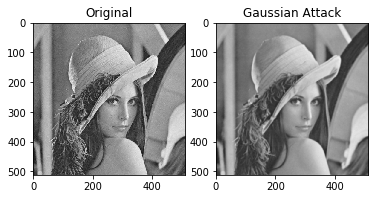

For  Gaussian Noise Attack
PSNR:  28.23464588991574 NC:  0.4303795245721357


In [5]:
Watermarking.watermark()
test.add_gaussian_noise("watermarked_lena.jpg")
test.plot_image("lena.jpg", 'gaussian_noise_attack.jpg', 'Gaussian Attack')
test.print_data("Gaussian Noise Attack", "gaussian_noise_attack.jpg", "lena.jpg")

For the Watermark image
For  Gaussian Noise Attack
PSNR:  6.820296249177014 NC:  0.5618510620463715


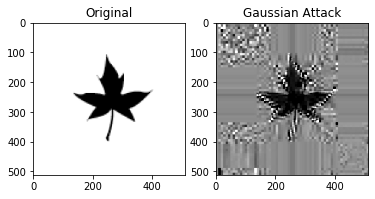

In [6]:
Watermarking.extracted(image_path="gaussian_noise_attack.jpg", extracted_watermark_path = "watermark_extracted_gaussian.jpg")
Watermarking.psnr_cal(img1="watermark1.jpg" , img2="watermark_extracted_gaussian.jpg")
print("For the Watermark image")
test.print_data("Gaussian Noise Attack", "watermark1.jpg", "watermark_extracted_gaussian.jpg")
test.plot_image("watermark1.jpg", 'watermark_extracted_gaussian.jpg', 'Gaussian Attack')

_______________________
## 2. Salt Pepper Noise Attack

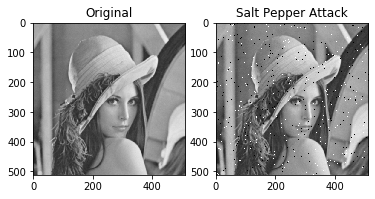

For  Salt and Pepper Noise Attack
PSNR:  22.420989859857578 NC:  0.42933454621573525


In [7]:
test.add_salt_pepper_noise("watermarked_lena.jpg", prob = 0.01)
test.plot_image("watermarked_lena.jpg", "salt_pepper_noise_attack.jpg", 'Salt Pepper Attack')
test.print_data("Salt and Pepper Noise Attack", "salt_pepper_noise_attack.jpg", "watermarked_lena.jpg")

For the Watermark image
For  Salt and Pepper Attack
PSNR:  17.265593616421476 NC:  0.4309904289674788


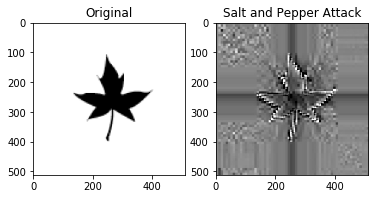

In [8]:
Watermarking.extracted(image_path="salt_pepper_noise_attack.jpg", extracted_watermark_path = "watermark_extracted_salt_pepper.jpg")
Watermarking.psnr_cal(img1="watermark1.jpg" , img2="watermark_extracted_salt_pepper.jpg")
print("For the Watermark image")
test.print_data("Salt and Pepper Attack", "watermark_extracted.jpg", "watermark_extracted_salt_pepper.jpg")
test.plot_image("watermark1.jpg", "watermark_extracted_salt_pepper.jpg", "Salt and Pepper Attack")

_______________________
## 3. Rotation Attack

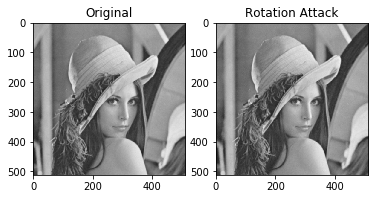

For  Rotation Attack
PSNR:  44.28053924438372 NC:  0.43185315915966377


In [9]:
test.add_rotation_test(0, "watermarked_lena.jpg")
test.plot_image("watermarked_lena.jpg", "rotation_attack.jpg", 'Rotation Attack')
test.print_data("Rotation Attack", "rotation_attack.jpg", "watermarked_lena.jpg")

For the Watermark image
For  Rotation Attack
PSNR:  27.91683566062289 NC:  0.4301861599364471


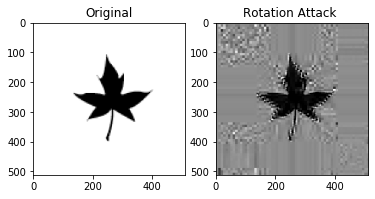

In [10]:
Watermarking.extracted(image_path="rotation_attack.jpg", extracted_watermark_path = "watermark_extracted_rotation.jpg")
Watermarking.psnr_cal(img1="watermark1.jpg" , img2="watermark_extracted_rotation.jpg")
print("For the Watermark image")
test.print_data("Rotation Attack", "watermark_extracted.jpg", "watermark_extracted_rotation.jpg")
test.plot_image("watermark1.jpg", "watermark_extracted_rotation.jpg", "Rotation Attack ")

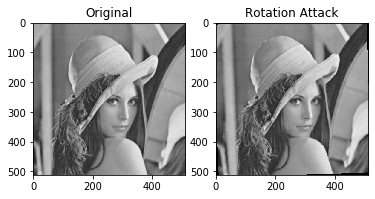

For  Rotation Attack
PSNR:  18.6503936639629 NC:  0.4290047253417349


In [11]:
test.add_rotation_test(2, "watermarked_lena.jpg")
test.plot_image("watermarked_lena.jpg", "rotation_attack.jpg", 'Rotation Attack')
test.print_data("Rotation Attack", "rotation_attack.jpg", "watermarked_lena.jpg")

For the Watermark image
For  Rotation Attack
PSNR:  9.32423466798742 NC:  0.4300382599784548


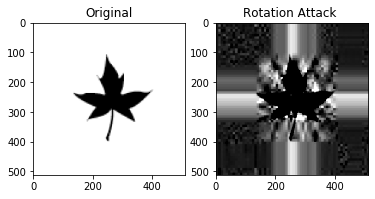

In [12]:
Watermarking.extracted(image_path="rotation_attack.jpg", extracted_watermark_path = "watermark_extracted_rotation.jpg")
Watermarking.psnr_cal(img1="watermark1.jpg" , img2="watermark_extracted_rotation.jpg")
print("For the Watermark image")
test.print_data("Rotation Attack", "watermark_extracted.jpg", "watermark_extracted_rotation.jpg")
test.plot_image("watermark1.jpg", "watermark_extracted_rotation.jpg", "Rotation Attack ")

___________________________________
## 4. Cropping Attack

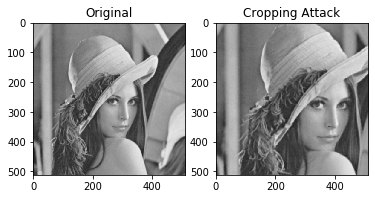

For  Crop Attack
PSNR:  12.118081665824318 NC:  0.4297473418089459


In [13]:
test.rescale_test("watermarked_lena.jpg")
test.plot_image("watermarked_lena.jpg", "cropped_attack.jpg", 'Cropping Attack') 
test.print_data("Crop Attack", "cropped_attack.jpg", "watermarked_lena.jpg")

For the Watermark image
For  Cropping Attack
PSNR:  7.073373452047952 NC:  0.4305890077600851


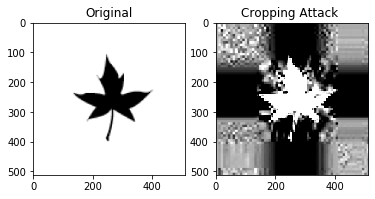

In [14]:
Watermarking.extracted(image_path="cropped_attack.jpg", extracted_watermark_path = "watermark_extracted_crop.jpg")
Watermarking.psnr_cal(img1="watermark1.jpg" , img2="watermark_extracted_crop.jpg")
print("For the Watermark image")
test.print_data("Cropping Attack", "watermark_extracted.jpg", "watermark_extracted_crop.jpg")
test.plot_image("watermark1.jpg", "watermark_extracted_crop.jpg", "Cropping Attack ")

_______________
## 5. Poisson Noise Attack

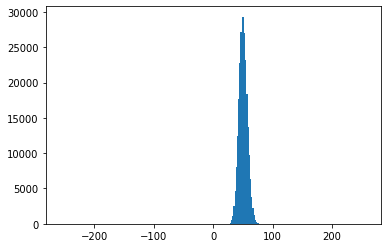

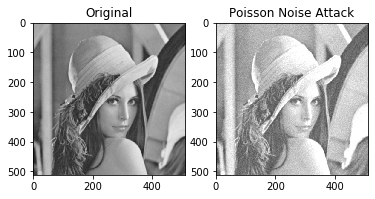

For  Poisson Noise Attack
PSNR:  14.20343930932278 NC:  0.430585671466096


In [15]:
test.add_poisson_noise("watermarked_lena.jpg")
test.plot_image("watermarked_lena.jpg", "poisson_noise_attack.jpg", 'Poisson Noise Attack')
test.print_data("Poisson Noise Attack", "poisson_noise_attack.jpg", "watermarked_lena.jpg")

For the Watermark image
For  Poisson Noise Attack
PSNR:  11.603700834753116 NC:  0


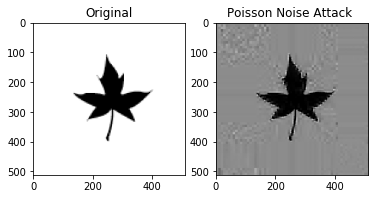

In [16]:
Watermarking.extracted(image_path="poisson_noise_attack.jpg", extracted_watermark_path = "watermark_extracted_poisson_noise.jpg")
Watermarking.psnr_cal(img1="watermark1.jpg" , img2="watermark_extracted_poisson_noise.jpg")
print("For the Watermark image")
test.print_data("Poisson Noise Attack", "watermark1.jpg", "watermark_extracted_poisson_noise.jpg")
test.plot_image("watermark1.jpg", "watermark_extracted.jpg", "Poisson Noise Attack ")

In [17]:
test.testing("watermarked_lena.jpg")

For  Gaussian Noise Attack
PSNR:  39.952800603871104 NC:  0.4297205761338935
For  Salt and Pepper Noise Attack
PSNR:  22.420989859857578 NC:  0.42933454621573525
For  Rotation Attack
PSNR:  18.6503936639629 NC:  0.4290047253417349
For  Crop Attack
PSNR:  12.118081665824318 NC:  0.4297473418089459
For  Poisson Noise Attack
PSNR:  14.20343930932278 NC:  0.430585671466096


In [ ]:
test.rotate("watermarked_lena.jpg")

Degree:  -90  ---PSNR:  11.197574658902358 ---NC:  0.4299991025544653
Degree:  -80  ---PSNR:  10.639179394585492 ---NC:  0.42923810181966526
Degree:  -70  ---PSNR:  10.241656840431565 ---NC:  0.43051385607265585
Degree:  -60  ---PSNR:  10.053895231582835 ---NC:  0.4299696877875044


In [19]:
x = cv2.imread("1.PNG")
x.shape

(300, 300, 3)